<a href="https://colab.research.google.com/github/acsenrafilho/ai.dojo.masterclass/blob/main/scripts/EP001-Primeira-IA-do-Zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masterclass - EP001 - Primeira IA do zero

## Objetivo 

Um concurso no Instagram de uma petshop está promovendo uma ação publicitária para pessoas com pets (cachorro e gato). Nosso objetivo é fazer uma IA que possa detectar se a fotografia enviada pelas pessoas que curtem a página da petshop tem na cena um cachorro ou um gato. Dessa forma a fotografia fica qualificada para participar da promoção.

## Dataset
Foi escolhido o dataset: [Kaggle - Classificação cachorro vs gato](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset?resource=download)

**Observação:** *O dataset foi carregado via API Kaggle para o Colab. Se desejar fazer o mesmo teste com o seu ambiente Google Colab, faça a [ integração com o Kaggle](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) utilizando as suas credenciais no Kaggle*


# Setup do ambiente

1. Ajuste da API Kaggle 
2. Download do dataset para o exemplo dessa masterclass
3. Unzip dataset

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! kaggle datasets download shaunthesheep/microsoft-catsvsdogs-dataset

 99% 782M/788M [00:11<00:00, 77.9MB/s]
100% 788M/788M [00:11<00:00, 71.0MB/s]


In [5]:
! unzip microsoft-catsvsdogs-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/55

#  Funções para ajudar no desenvolvimento do exemplo

In [22]:
# Libs de suporte
import random
import os

# Libs de leitura e processamento de dados
import numpy as np
import cv2 as cv

# Libs de visualização
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Libs de machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def checkImagesIntegrity():
  num_skipped = 0
  for folder_name in ("Cat", "Dog"):
      folder_path = os.path.join("PetImages", folder_name)
      for fname in os.listdir(folder_path):
          fpath = os.path.join(folder_path, fname)
          try:
              fobj = open(fpath, "rb")
              is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
          finally:
              fobj.close()

          if not is_jfif:
              num_skipped += 1
              # Delete corrupted image
              os.remove(fpath)

  return num_skipped

In [ ]:

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = inputs

  # Entry block
  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128, 256, 512, 728]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

In [ ]:
def make_prediction(image_path, image_size):
  img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Cria dimensão do batch

  predictions = model.predict(img_array)
  return predictions[0]

# Etapa 1 - Análise e montagem do dataset 

Deleted 1590 images
Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


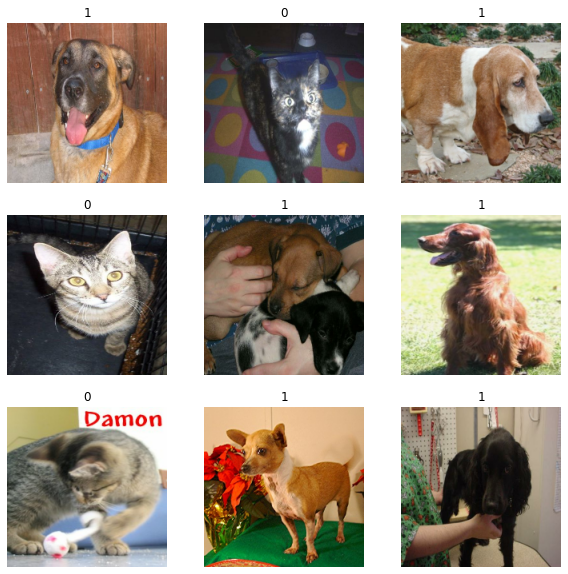

In [7]:
# Carregar as imagens para treino e validação do treinamento
# Primeiro: Verificar se há imagens corrompidas e remove-las
corrupted_images = checkImagesIntegrity()
print("Deleted %d images" % corrupted_images)

# Definir qual a característica padrão das imagens e lote de treino
image_size = (200, 200)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

# Ilustrar algumas imagens para entender como está definido o dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Etapa 2 - Preparação do treinamento da IA

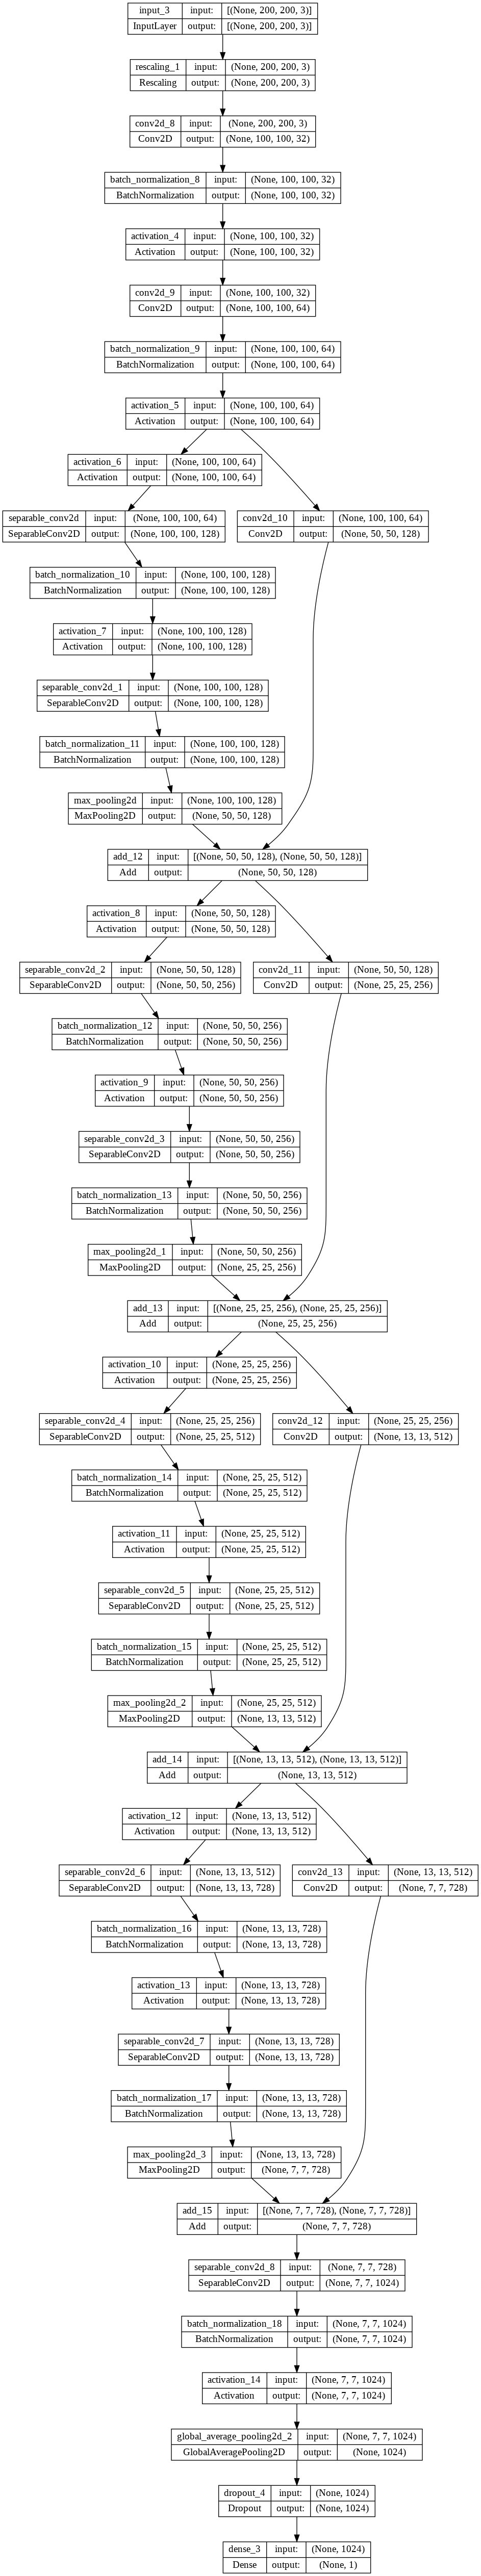

In [18]:
# Atribuição do modelo de IA a ser utilizado (arquitetura CNN)
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Etapa 3 - Iniciar treino do modelo

In [45]:
# Definir parâmetros de treinamento
epochs = 10
optimizer_type = keras.optimizers.Adam(1e-3)
loss_type = "binary_crossentropy"
metric_types = ["accuracy"]

# Definir uma função de parada, para terminar o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

# Compilar os parâmetros para iniciar o treinamento
model.compile(
    optimizer=optimizer_type,
    loss=loss_type,
    metrics=metric_types,
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 200, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 100, 100, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
# Iniciar treinamento
model.fit(
    train_dataset, epochs=epochs, callbacks=callbacks, validation_data=val_dataset,
)

# Testar modelo com exemplos

## Situação 1
### Como o modelo responde a imagens do mesmo contexto que o dataset de treino?

Aqui neste caso nós adicionamos algumas imagens do mesmo repositório dos dados utilizados no treino e validação.

As imagens desses testes estão no repositório Github. Faça o upload delas no Google Colab para poder executar o trecho de exemplo.

**IMPORTANTE:** *Nós não usamos imagens que foram incluídas na etapa de treino, pois isso iria deturpar o resultado do modelo de IA*


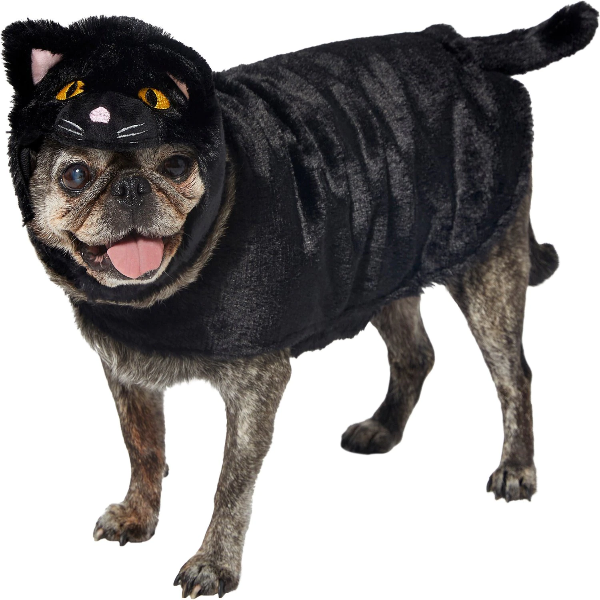

1/1 [==============================] - 0s 18ms/step
Resposta do modelo IA: 0.83 porcento probabilidade se ser gato e 99.17 porcento probabilidade de ser cachorro.


In [39]:
# Fazer predição com a imagem de exemplo
cv2_imshow(cv.resize(cv.imread("situacao-1.png"), (600,600)))

score = make_prediction("situacao-1.png", image_size)
print(
      "Resposta do modelo IA: %.2f porcento probabilidade se ser gato e %.2f porcento probabilidade de ser cachorro."
      % (100 * (1 - score), 100 * score)
  )

## Situação 2
### Se não tiver cachorro ou gato, o algoritmo retorna o que?

O modelo não sabe nada além do que é cachorro ou gato, pois era somente isso que foi fornecido no dataset de treinamento.

Logo, não podemos esperar que o modelo acerte qualquer outro tipo de classe.


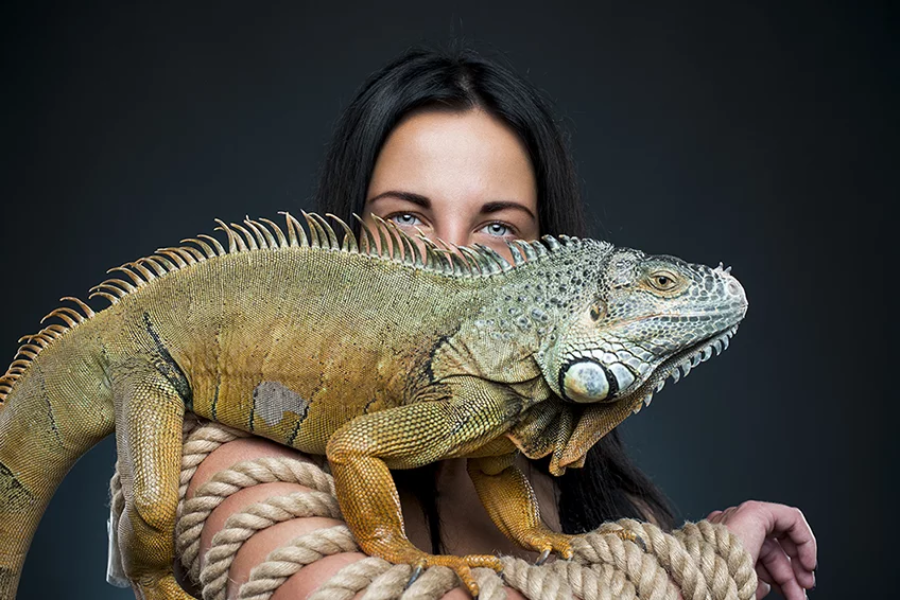

1/1 [==============================] - 0s 23ms/step
Resposta do modelo IA: 99.71 porcento probabilidade se ser gato e 0.29 porcento probabilidade de ser cachorro.


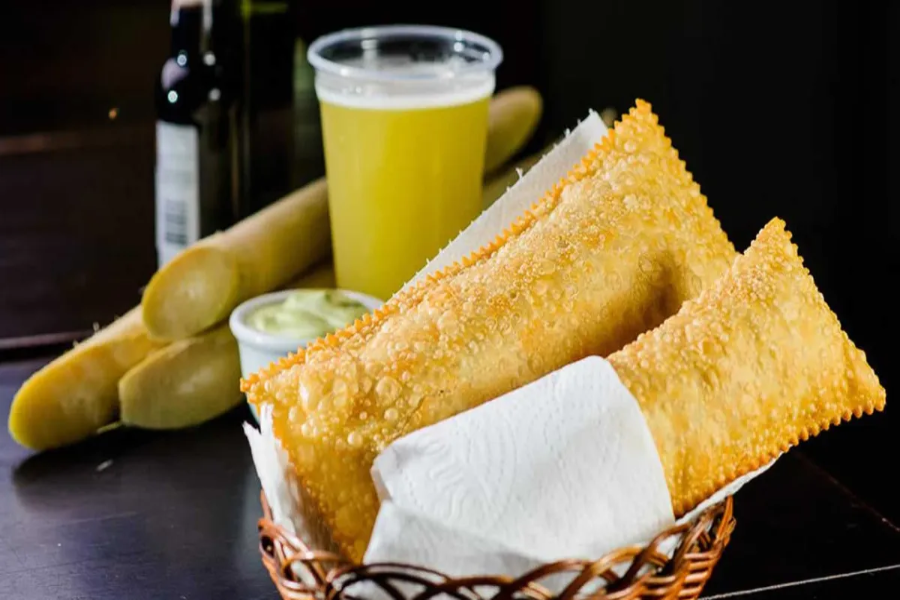

1/1 [==============================] - 0s 24ms/step
Resposta do modelo IA: 3.69 porcento probabilidade se ser gato e 96.31 porcento probabilidade de ser cachorro.


In [43]:
# Fazer predição com a imagem de exemplo
cv2_imshow(cv.resize(cv.imread("situacao-2.png"), (900,600)))

score = make_prediction("situacao-2.png", image_size)
print(
      "Resposta do modelo IA: %.2f porcento probabilidade se ser gato e %.2f porcento probabilidade de ser cachorro."
      % (100 * (1 - score), 100 * score)
  )

cv2_imshow(cv.resize(cv.imread("situacao-2-b.png"), (900,600)))

score = make_prediction("situacao-2-b.png", image_size)
print(
      "Resposta do modelo IA: %.2f porcento probabilidade se ser gato e %.2f porcento probabilidade de ser cachorro."
      % (100 * (1 - score), 100 * score)
  )

## Situação 3
### Quantos animais há na cena? Cenas com mais objetos o algoritmo consegue responder bem?

De fato o modelo foi treinado apenas para dizer se na fotografia consta um cachorro ou um gato, mas não sabe nada mais do que isso.

Modelos mais complexos precisam ser montados caso queira saber informações como quantidade de animais, tipos a mais de animais, etc.


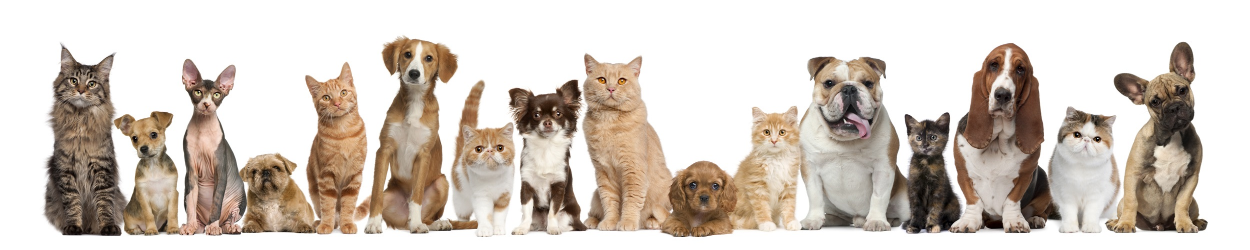

1/1 [==============================] - 0s 18ms/step
Resposta do modelo IA: 72.74 porcento probabilidade se ser gato e 27.26 porcento probabilidade de ser cachorro.


In [44]:
# Fazer predição com a imagem de exemplo
cv2_imshow(cv.resize(cv.imread("situacao-3.png"), (1250,250)))

score = make_prediction("situacao-3.png", image_size)
print(
      "Resposta do modelo IA: %.2f porcento probabilidade se ser gato e %.2f porcento probabilidade de ser cachorro."
      % (100 * (1 - score), 100 * score)
  )